## Εθνικό Μετσόβιο Πολυτεχνείο 
## Σχολή Ηλεκτρολόγων Μηχανικών & Μηχανικών Υπολογιστών


### Μάθημα: Στοχαστικές διαδικασίες
### Διδάσκων: Μιχαήλ Λουλάκης
### Ακαδημαϊκό έτος: 2017-2018


### Ιωάννης Κ. Γεωργακόπουλος
### Α.Μ.: 03111512


# 9η Εργαστηριακή Άσκηση

Σε αυτό το εργαστήριο θα εργαστούμε πάνω σε ενδιαφέρουσες εφαρμογές των τεχνικών που μάθαμε στο προηγούμενο.
Στο τέλος μάλιστα, θα κατασκευάσουμε μία προσεγγιστική λύση του προβλήματος του πλανώδιου πωλητή.

Στα πλαίσια του εργαστηρίου θα χρησιμοποιήσουμε τις παρακάτω βιβλιοθήκες.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6)  # increase default figure size

np.random.seed(2018)  # for reproducibility

# Άσκηση 1: Προσομοιωμένη Ανόπτηση

Στην άσκηση αυτή θα χρησιμοποιήσουμε τη μέθοδο της προσομοιωμένης ανόπτησης
([simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing)) για
να βρουμε το ελάχιστο μιας συνάρτησης $V: \mathbb{R} \to \mathbb{R}$. 
Εν προκειμένω θα μελετήσουμε την πολυωνυμική συνάρτηση:

$$ V(x) = \frac{13}{90} x^4 - \frac{3}{10} x^3 - \frac{101}{45} x^2 \frac{13}{15}x + 4$$

Η γραφική της παράσταση κατασκευάζεται στο παρακάτω κελί.


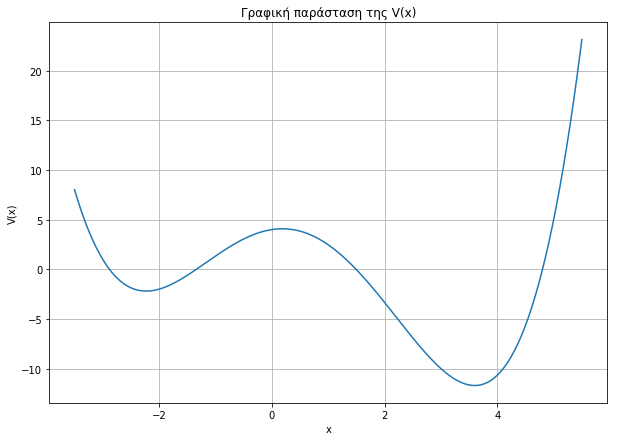

In [2]:
def V(x):
    """Energy (objective) function to minimize"""
    return np.polyval((13/90, -3/10, -101/45, 13/15, 4.0), x)

x = np.linspace(-3.5, 5.5, 1000) #Διαλέγουμε κατάλληλα όρια ώστε να φαίνονται τα ακρότατα της συνάρτησης

plt.figure(figsize = (10, 7))
plt.plot(x, V(x))
plt.xlabel("x")
plt.ylabel("V(x)")
plt.title('Γραφική παράσταση της V(x)')
plt.grid(True)
plt.show()

Θα υπολογίσουμε αιτιοκρατικά το τοπικό και ολικό ελάχιστο, ώστε να τα έχουμε ως benchmarks στη συνέχεια.


In [3]:
#np.argmin(V(x))

LocalMin = -2.2293
GlobalMin = 3.60005

Ακολουθεί ο αλγόριθμος Metropolis-Hastings για την στοχαστική προσεγγιστική εύρεση των ελαχίστων.

In [4]:
def sim_anneal(f, x_low, x_high,
               T=2.0, T_min=2**(-12), 
               cool_factor=0.9, cool_sch=100,
               delta = 1.0, shrink_factor=0.5, shrink_thres=0.25,
               trace = False):
    
    # Initialize
    x = np.random.uniform(x_low, x_high)
    f_cur = f(x)  # current value of f
    steps = accepted = 0
    if trace: path = []

    # Main loop
    while T > T_min:
        
        # proposed new position
        x_new = x + np.random.uniform(-delta, delta)
        if x_new > x_high or x_new < x_low:
            continue  # skip this proposal
        f_new = f(x_new)

        # accept/reject jump
        if np.log(np.random.rand()) < -(f_new - f_cur) / T :
            x, f_cur = x_new, f_new
            accepted += 1            
                
        # Cooling
        if steps == cool_sch:  # time for the next cooling
            T *= cool_factor  # cool down
            # Adjust Search Space
            if accepted / steps < shrink_thres:
                delta *= shrink_factor
            steps = accepted = 0
        
        if trace: path.append(x)
        steps += 1        
        
    
    if trace: return path
    return x

Οι παράμετροι της συνάρτησης `sim_anneal` είναι:

* **`f`**: η συνάρτηση που θέλουμε να ελαχιστοποιήσουμε
* **`x_low, x_high`**: Το όρια μέσα στα οποία ψάχνουμε να βρούμε το ελάχιστο
* **`T, T_min`**: Η αρχική και η τελική θερμοκρασία της "ανόπτησης"
* **`cool_factor`**: Πόσο μειώνεται η θερμοκρασία σε κάθε κύκλο ψύξης (ποσοστό της προηγούμενης)
* **`cool_sch`**: Κάθε πόσα βήματα να μειώνεται η θερμοκρασία
* **`delta`**: Ακτίνα από την οποία θα προτείνουμε άλμα
* **`shrink_factor`**: Πόσο θα μειώσουμε το `delta` αν δούμε ότι η μέθοδος έχει κολλήσει
* **`shirnk_thres`**: Ποσοστό το επιτυχημένων αλμάτων κάτω από το οποίο θεωρούμε ότι το σωματίδιο έχει κολλήσει.
* **`trace`**: Αν θέλουμε να μας γυρίσει όλη την διαδρομή ή μόνο την τελική θέση

Επομένως για να βρούμε το ελάχιστο της συνάρτησης $V$ που ορίσαμε προηγουμένως στο
διάστημα $(-3.5, 5.5)$ τρέχουμε την συνάρτηση με τις εξής παραμέτρους.

*Παρατήρηση: Ζητάμε όλο το μονοπάτι του σωματιδίου για να το πλοτάρουμε αργότερα.*

In [5]:
# Parameters
T_start, T_end = 2.0, 2**(-12)
cool_sch, cool_factor = 100, 0.99

path = sim_anneal(V, -3.5, 5.5, delta = 1.,                      
                  T = T_start, T_min = T_end,
                  cool_factor = cool_factor, 
                  cool_sch = cool_sch,
                  trace = True)  # keep the default for the rest, (-3.5,5) ώστε να βρω τα ελάχιστα 

path[-1]  # last position

3.5963735407238038

Το επόμενο κελί κώδικα οπτικοποιεί τη διαδικασία. (Σε pop-up window, όπως στο προηγούμενο)

Διαβάζοντας το source code του animate_simanneal.py, παρατηρήσαμε ότι το πολυώνυμο με το οποίο μας ζητήθηκε να εργαστούμε, λαμβάνεται αν δόσουμε ως όρισμα -minima 2.

In [23]:
%matplotlib qt
%run ../animate_simanneal.py -minima 2

Στη συνέχεια, τρέχουμε το παρακάτω κελί ώστε τα επόμενα διαγράμματα να εμφανίζονται μέσα στο notebook.

In [7]:
%matplotlib inline

### Ερώτημα Α)

Θα φτιάξουμε ένα loop με 200 επαναλήψεις και θα συγκρίνουμε την τιμή που βρίσκουμε με τα 2 benchmarks κάθε φορά, ώστε να υπολογίσουμε το ποσοστό.

In [11]:
N = 10 # Αρχικοποίηση επαναλήψεων

N_Local  = 0 # Πλήθος output που βρίσκουν το Local Minima
N_Global = 0 # Πλήθος output που βρίσκουν το Global Minima 

for i in range(N):
    path = sim_anneal(V, -3.5, 5, delta = 1.,                      
                  T = T_start, T_min = T_end,
                  cool_factor = cool_factor, 
                  cool_sch = cool_sch,
                  trace = True)  # keep the default for the rest, (-3.5,5) ώστε να βρω τα ελάχιστα 
     
    if abs(path[-1]-LocalMin)<=0.05:
        N_Local  += 1
    if abs(path[-1]-GlobalMin)<=0.05:
        N_Global += 1

print('Ποσοστό εύρεσης κάποιου τοπικού ελαχίστου: ', 100*N_Local/N,'%')
print('Ποσοστό εύρεσης ολικού ελαχίστου:        ', 100*N_Global/N, '%')    

Ποσοστό εύρεσης κάποιου τοπικού ελαχίστου:  0.0 %
Ποσοστό εύρεσης ολικού ελαχίστου:         100.0 %


Παρατηρούμε ότι ο αλγόριθμος βρίσκει με εξαιρετικά μεγάλη πιθανότητα το ολικό ελάχιστο. Αυτό συμβαίνει επειδή ο default cool factor που έχουμε δώσει είναι μεγάλος.

### Ερώτημα Β)

Θα φτιάξουμε μια λίστα με τα cool factors και θα κατασκευάσουμε την λίστα με την πιθανότητα εύρεσης τοπικού ελαχίστου.

In [9]:
new_cool_factor = [0.25, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
Global = np.zeros(len(new_cool_factor), dtype=float)

for j,i in enumerate(new_cool_factor): 

    for w in range(N):
        
        path = sim_anneal(V, -3.5, 5.5, cool_factor= i, trace = True)
        # print(path[-1])

        if abs(path[-1]-GlobalMin)<=0.05:
            Global[j] += 1
    
print(Global/N)

[0.6 0.9 0.7 0.5 0.7 0.7 1.  1. ]


Ακολουθεί ο κώδιξ με το ζητούμενο διάγραμμα.

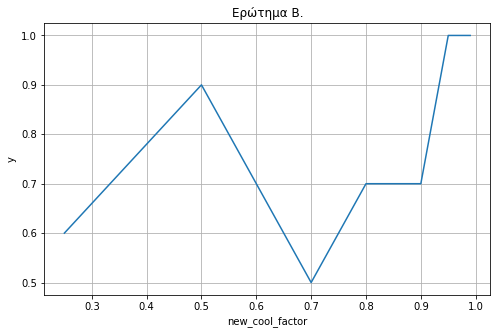

In [10]:
y = Global/N

# Let's plot (x,y)
plt.figure(figsize = (8, 5))
plt.plot(new_cool_factor, y)
# Specify some extra attributes
plt.xlabel('new_cool_factor')
plt.ylabel('y')
plt.title('Ερώτημα Β.')
plt.grid(True)

Τα αποτελέσματα είναι ενδιαφέροντα και ταυτόχρονα αναμενόμενα, καθώς δείχνουν ότι όσο αυξάνουμε τον cool_factor, τα άλματά μας γίνοται μικρότερα άρα και η αναζήτηση γίνεται πιο αυστηρή οπότε βρίσκουμε με μεγαλύτερη πιθανότητα το σωστό ελάχιστο.